In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv("/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")

In [3]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
 df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [5]:
df.dropna(axis = 0, inplace = True)

In [6]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [7]:
df.shape

(162969, 2)

In [8]:
#Mapping the categories

df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral',1.0:'Positive'})

In [9]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


# EDA

<Axes: xlabel='category'>

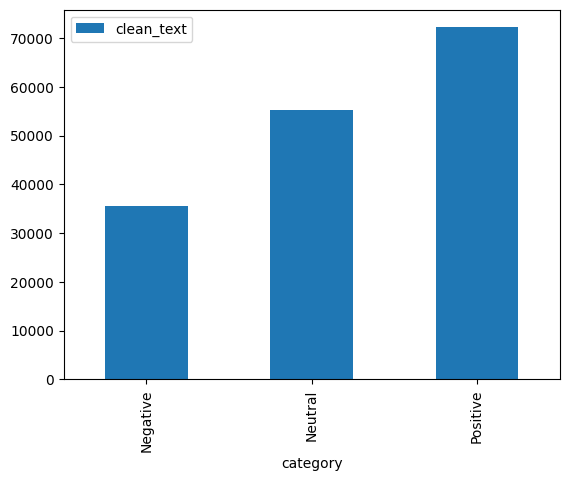

In [10]:
# Visulaization
df.groupby('category').count().plot(kind = 'bar')

<Axes: >

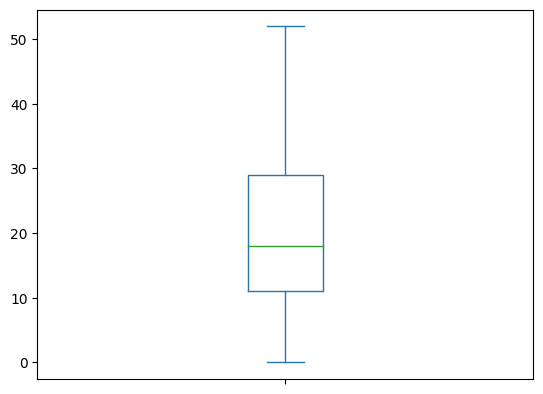

In [11]:
#calculating tweet length

tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])
tweet_len.plot(kind = 'box')

# Data Preprocessing

In [13]:
import re
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()
def tweet_to_words(tweet):
    
    text = tweet.lower()
#     text = re.sub(r"[a-zA-Z0-9]", " ", text)
    #tokenize
    words = text.split()
    #Removing Stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    #stemming
    words = [stemmer.stem(w) for w in words]
    return words

In [14]:
#preprocssing application
x = list(map(tweet_to_words, df['clean_text']))

In [15]:
# label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])

In [16]:
print(x[0])
print([y[0]])

['modi', 'promis', '“minimum', 'govern', 'maximum', 'governance”', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
[0]


In [19]:
# train test split
from sklearn.model_selection import train_test_split
Y = pd.get_dummies(df['category'])
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size= 0.2, random_state= 1)
x_train, x_val, Y_train, Y_val = train_test_split(x, Y, test_size = 0.25, random_state= 1)

# BOW feature extraction

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000
count_vector = CountVectorizer(max_features= vocabulary_size,
                              preprocessor= lambda x: x,
                              tokenizer= lambda x: x)

#fitting training data
x_train = count_vector.fit_transform(x_train).toarray()

#Transform test data
x_test = count_vector.transform(x_test).toarray()

In [36]:
print(count_vector.get_feature_names_out()[0:200])

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14]


# Tokenizing and padding

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    x = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    x = pad_sequences(x, padding='post', maxlen=max_len)
    # return sequences
    return x, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
x, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', x[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [44]:


import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)



In [45]:
Y = pd.get_dummies(df['category'])
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.2, random_state=1)
x_train, x_val, Y_train, Y_val = train_test_split(x_train, Y_train, test_size=0.25, random_state=1)
print('Train Set ->', x_train.shape, Y_train.shape)
print('Validation Set ->', x_val.shape, Y_val.shape)
print('Test Set ->', x_test.shape, Y_test.shape)

Train Set -> (97781, 50) (97781, 3)
Validation Set -> (32594, 50) (32594, 3)
Test Set -> (32594, 50) (32594, 3)


In [46]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


# Bidirectional LSTM with NN

In [51]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [53]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(x_train, Y_train,
                      validation_data=(x_val, Y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5773 - loss: 0.8993 - precision_2: 0.6338 - recall_2: 0.4064 - val_accuracy: 0.8792 - val_loss: 0.3696 - val_precision_2: 0.8821 - val_recall_2: 0.8747
Epoch 2/20
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8883 - loss: 0.3563 - precision_2: 0.8911 - recall_2: 0.8842 - val_accuracy: 0.9207 - val_loss: 0.2629 - val_precision_2: 0.9222 - val_recall_2: 0.9192
Epoch 3/20
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9197 - loss: 0.2767 - precision_2: 0.9227 - recall_2: 0.9171 - val_accuracy: 0.9357 - val_loss: 0.2220 - val_precision_2: 0.9398 - val_recall_2: 0.9327
Epoch 4/20
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9380 - loss: 0.2257 - precision_2: 0.9417 - recall_2: 0.9344 - val_accuracy: 0.9414 - val_loss: 0.2096 - val_precision_2: 0.9449 - val_recall_2: 0.9388
Epoch 5/20
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9454 - loss: 0.2032 - precision_2: 0.9492 

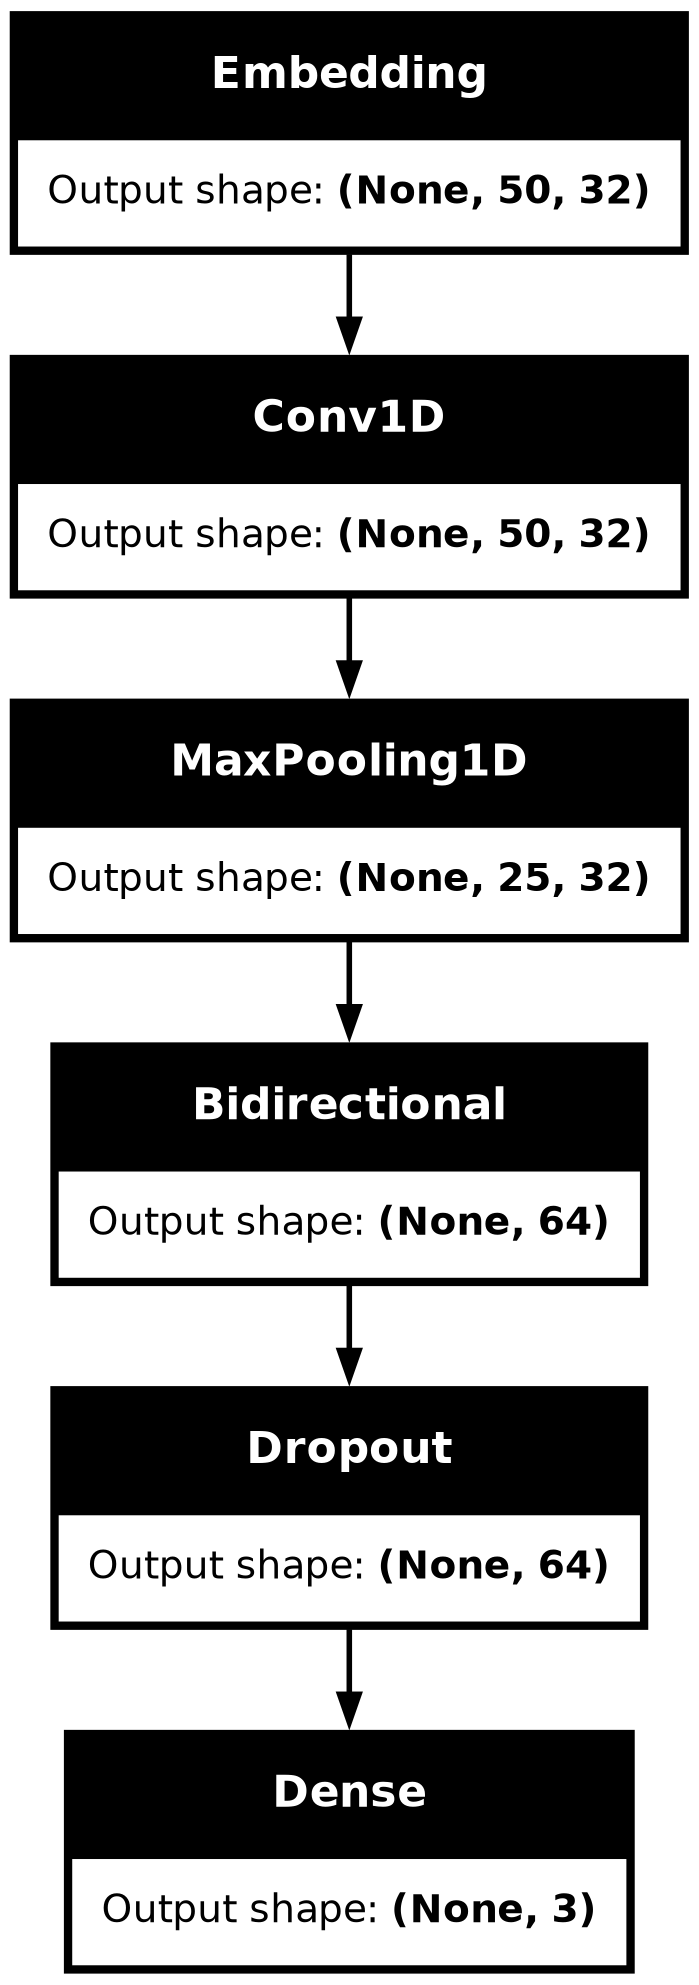

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [56]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(x_test, Y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9469
Precision : 0.9509
Recall    : 0.9434
F1 Score  : 0.9472


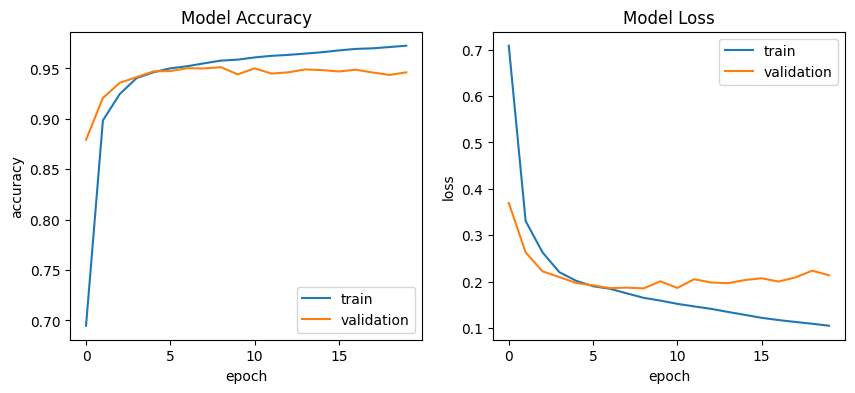

In [59]:
import matplotlib.pyplot as plt
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [62]:
# Save the model architecture & the weights
model.save('best_model.keras')
print('Best model saved')

Best model saved


In [64]:


from keras.models import load_model

# Load model
model = load_model('/kaggle/working/best_model.keras')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])



/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 13 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['kernel', 'recurrent_kernel', 'bias']

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>]